In [2]:
# Code borrowed from https://www.kaggle.com/delllectron/fire-detection-computer-vision/notebook
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')


import os
import tensorflow as tf

from tensorflow.keras.applications import xception
from tensorflow.keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import cv2
from scipy.stats import uniform

from tqdm import tqdm
from glob import glob


from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking
from tensorflow.keras.utils import  to_categorical

from collections import defaultdict

# np_utils,

# Read in data

In [3]:
base_folder = '../data/'
data_folder = base_folder + 'fire-dataset/'
train_data_folder = data_folder + 'wildfire'
test_date_folder  = data_folder + 'non-wildfire'

categories = ['wildfire', 'non-wildfire']
len_categories = len(categories)

In [4]:
len_categories

2

In [5]:
image_count = defaultdict(int)
train_data = []

for i , category in enumerate(categories):
    class_folder = os.path.join(data_folder, category)
    label = category
    
    for path in os.listdir(os.path.join(class_folder)):
        image_count[category] += 1
        train_data.append(['{}/{}'.format(category, path), i, category])

In [6]:
image_count

defaultdict(int, {'wildfire': 633, 'non-wildfire': 1318})

In [7]:
train_data[-10:]

[['non-wildfire/california-1587277_960_720.jpg', 1, 'non-wildfire'],
 ['non-wildfire/875454-fire-background-images-3840x2.jpg', 1, 'non-wildfire'],
 ['non-wildfire/small-mountain-river-in-the-valley-4.jpg', 1, 'non-wildfire'],
 ['non-wildfire/building-fire-pit-ideas.jpg', 1, 'non-wildfire'],
 ['non-wildfire/100127_A_Ind_Fire_Buzz_005.jpg', 1, 'non-wildfire'],
 ['non-wildfire/294.ngsversion.1488483019115.adapt.1.jpg', 1, 'non-wildfire'],
 ['non-wildfire/Pine_forest_in_Sweden.jpg', 1, 'non-wildfire'],
 ['non-wildfire/the-forest-map-karte-overall-1.jpg', 1, 'non-wildfire'],
 ['non-wildfire/Forest-Wallpaper-Background-HD.jpg', 1, 'non-wildfire'],
 ['non-wildfire/82300-050-DA3B1E0C.jpg', 1, 'non-wildfire']]

In [8]:
#create a dataframe
df = pd.DataFrame(train_data, columns=['file', 'id', 'label'])
df.shape
df.head()

,file,id,label
0,wildfire/34010-1920x1280.jpg,0,wildfire
1,wildfire/201281992030339265_8.jpg,0,wildfire
2,wildfire/Hayden-Pass-Fire-noon-July-14-2016.jpg,0,wildfire
3,wildfire/silverado-resort-california-wildfire.jpg,0,wildfire
4,wildfire/WA_15-08-16_0809-Chelan-KGreer-1200x.jpg,0,wildfire


In [71]:
df.to_csv('../data/fire-dataset/data_df.csv', index=False)

# mask the image


In [9]:
#masking function
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

#image segmentation function
def segment_image(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#sharpen the image
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

# function to get an image
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_folder, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

# show sample images

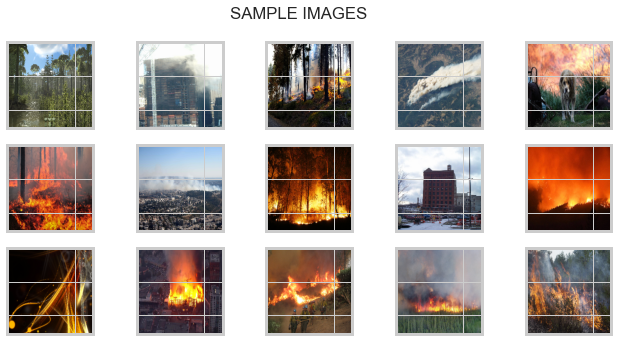

In [10]:
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('SAMPLE IMAGES');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow((read_img(df['file'][np.random.randint(1000)], (255,255)))/255.);
plt.show();

# process the image to create a mask for fire

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


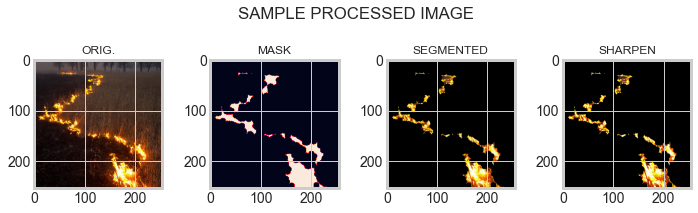

In [11]:
#get an image
img = read_img(df['file'][105],(255,255))
#mask
image_mask = create_mask_for_plant(img)
#segmentation
image_segmented = segment_image(img)
#sharpen the image
image_sharpen = sharpen_image(image_segmented)

fig, ax = plt.subplots(1, 4, figsize=(10, 5));
plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIG.', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[2].set_title('SEGMENTED', fontsize=12)
ax[3].set_title('SHARPEN', fontsize=12)


ax[0].imshow(img/255);
ax[1].imshow(image_mask);
ax[2].imshow(image_segmented);
ax[3].imshow(image_sharpen);

## Xception feature extraction
- This might not work on an embedded device...

In [12]:
INPUT_SIZE=255

##preprocess the input
X_train = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, df.shape[1]), dtype='float')
for i, file in tqdm(enumerate(df['file'])):
    #read image
    img = read_img(file,(INPUT_SIZE,INPUT_SIZE))
    #masking and segmentation
    image_segmented = segment_image(img)
    #sharpen
    image_sharpen = sharpen_image(image_segmented)
    x = xception.preprocess_input(np.expand_dims(image_sharpen.copy(), axis=0)) # one image at a time
    X_train[i] = x

651it [00:21, 23.65it/s]/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/climate-Oxu41Kqh-py3.8/lib/python3.8/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
1951it [01:24, 23.11it/s]


In [17]:
image_sharpen.shape

(255, 255, 3)

In [18]:
np.expand_dims(image_sharpen.copy(), axis=0).shape

(1, 255, 255, 3)

In [21]:
X_train[0].min(), X_train[0].max()

(-1.0022499561309814, -0.9883046746253967)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


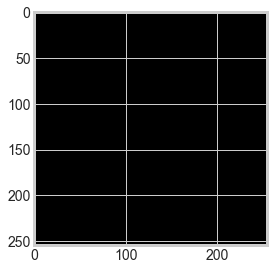

In [22]:
plt.imshow(X_train[0])

# split the data

In [23]:
X_train.shape

(1951, 255, 255, 3)

In [25]:
y = df['id']

- include indicies to get original images back

In [28]:
y = df['id']
train_x, train_val,  y_train, y_val, train_indicies, val_indicies = train_test_split(X_train, 
                                                                                     y, list(y.index), 
                                                                                     test_size=0.2,
                                                                                     random_state=101)

In [30]:
print('FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==0].shape[0])
print('NON-FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==1].shape[0])

FIRE IMAGES ON TRAINING DATA:  510
NON-FIRE IMAGES ON TRAINING DATA:  1050


In [31]:
##get the features
xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
bf_train_x = xception_bf.predict(train_x, batch_size=32, verbose=1)
bf_train_val = xception_bf.predict(train_val, batch_size=32, verbose=1)

2021-12-29 11:26:00.566453: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


13/13 [==============================] - 27s 2s/step


In [32]:
#print shape of feature and size
print('Train Shape: ', bf_train_x.shape)
print('Train Size: ', bf_train_x.size)

print('Validation Shape: ', bf_train_val.shape)
print('Validation Size: ', bf_train_val.size)

Train Shape:  (1560, 2048)
Train Size:  3194880
Validation Shape:  (391, 2048)
Validation Size:  800768


# dl

In [72]:
bf_train_x.shape

(1560, 2048)

In [34]:
#keras Sequential model
model = Sequential()
model.add(Dense(units = 256 , activation = 'relu', input_dim=bf_train_x.shape[1]))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 541,057
Trainable params: 541,057
Non-trainable params: 0
_________________________________________________________________


In [35]:
#train the model @ 100 epochs
history = model.fit(bf_train_x, y_train, epochs=150, batch_size=32);

Epoch 1/150
49/49 [==============================] - 1s 2ms/step - loss: 0.6254 - accuracy: 0.6622
Epoch 2/150
49/49 [==============================] - 0s 2ms/step - loss: 0.5997 - accuracy: 0.6840
Epoch 3/150
49/49 [==============================] - 0s 2ms/step - loss: 0.5937 - accuracy: 0.6795
Epoch 4/150
49/49 [==============================] - 0s 2ms/step - loss: 0.5784 - accuracy: 0.6872
Epoch 5/150
49/49 [==============================] - 0s 2ms/step - loss: 0.5549 - accuracy: 0.7135
Epoch 6/150
49/49 [==============================] - 0s 2ms/step - loss: 0.5400 - accuracy: 0.7179
Epoch 7/150
49/49 [==============================] - 0s 2ms/step - loss: 0.5322 - accuracy: 0.7199
Epoch 8/150
49/49 [==============================] - 0s 2ms/step - loss: 0.5192 - accuracy: 0.7295
Epoch 9/150
49/49 [==============================] - 0s 2ms/step - loss: 0.5543 - accuracy: 0.7045
Epoch 10/150
49/49 [==============================] - 0s 2ms/step - loss: 0.5146 - accuracy: 0.7397
Epoch 11/

- save model to convert to tflite

In [68]:
model.save('../models/xception_to_sequential.h5')

# History

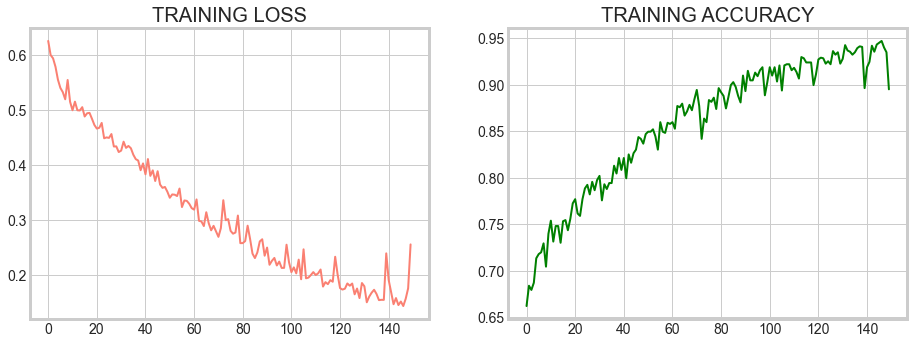

In [37]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('TRAINING LOSS');
ax[1].set_title('TRAINING ACCURACY');


ax[0].plot(history.history['loss'], color= 'salmon',lw=2);
ax[1].plot(history.history['accuracy'], color= 'green',lw=2);

In [39]:
#predict the validation data
predictions = model.predict(bf_train_val)

In [42]:
# has wildire = 0
predictions[:10]

array([[0.99404275],
       [0.9184531 ],
       [1.        ],
       [0.99857926],
       [0.9809526 ],
       [0.82178587],
       [0.2812991 ],
       [0.09231275],
       [1.        ],
       [0.12112162]], dtype=float32)

In [43]:
predictions .min()

8.794482e-25

In [44]:
predictions .max()

1.0

In [45]:
predictions[predictions > .50] = 1 # threshold

In [46]:
predictions[predictions <= .50] = 0

# classification report

In [47]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.59      0.50      0.54       123
           1       0.79      0.84      0.81       268

    accuracy                           0.73       391
   macro avg       0.69      0.67      0.68       391
weighted avg       0.72      0.73      0.73       391



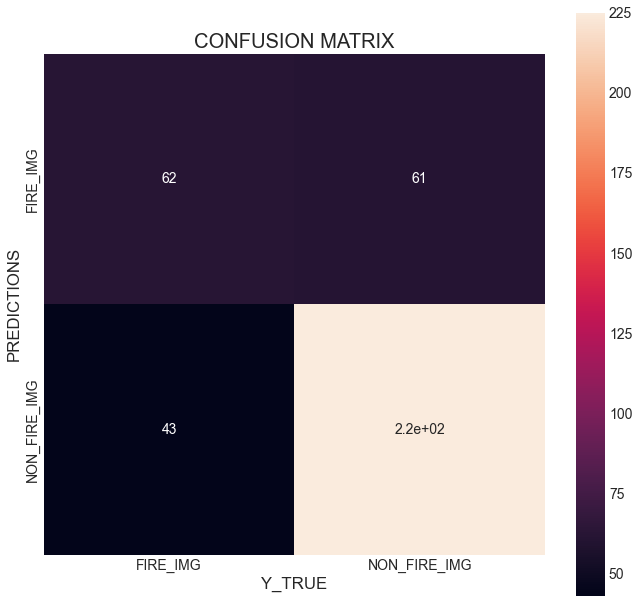

In [48]:
confusion_mat = confusion_matrix(y_val, predictions)

plt.figure(figsize=(10,10))
sns.heatmap(confusion_mat, square=True, annot=True,
            yticklabels=['FIRE_IMG', 'NON_FIRE_IMG'],
            xticklabels=['FIRE_IMG', 'NON_FIRE_IMG']);
plt.title('CONFUSION MATRIX');
plt.xlabel('Y_TRUE');
plt.ylabel("PREDICTIONS");

## See which ones we are correct / wrong on

In [49]:
df

,file,id,label
0,wildfire/34010-1920x1280.jpg,0,wildfire
1,wildfire/201281992030339265_8.jpg,0,wildfire
2,wildfire/Hayden-Pass-Fire-noon-July-14-2016.jpg,0,wildfire
3,wildfire/silverado-resort-california-wildfire.jpg,0,wildfire
4,wildfire/WA_15-08-16_0809-Chelan-KGreer-1200x.jpg,0,wildfire
...,...,...,...
1946,non-wildfire/294.ngsversion.1488483019115.adap...,1,non-wildfire
1947,non-wildfire/Pine_forest_in_Sweden.jpg,1,non-wildfire
1948,non-wildfire/the-forest-map-karte-overall-1.jpg,1,non-wildfire
1949,non-wildfire/Forest-Wallpaper-Background-HD.jpg,1,non-wildfire


In [53]:
y_val[98]

0

In [61]:
df[df.index == 247]

,file,id,label
247,wildfire/swinley-forest-fire-1305023400-view-.jpg,0,wildfire


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 true
247  val_index 
incorrect
[1.] prediction
wildfire/swinley-forest-fire-1305023400-view-.jpg image_name


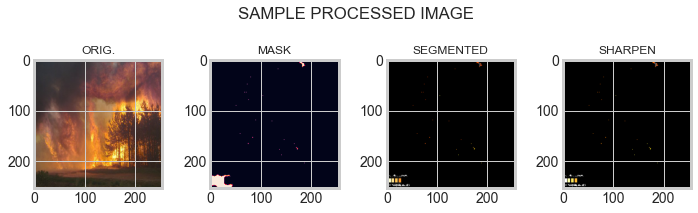

1 true
1056  val_index 
incorrect
[0.] prediction


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


non-wildfire/2004-06-06_nantahala-cheoah-joyce-ki.jpg image_name


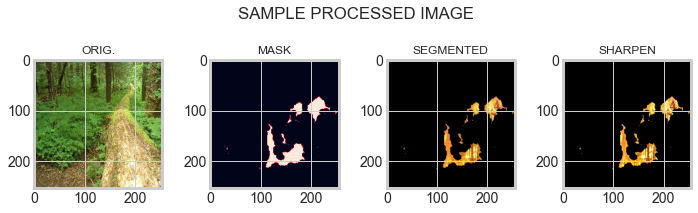

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 true
1661  val_index 
incorrect
[0.] prediction
non-wildfire/660796.jpg image_name


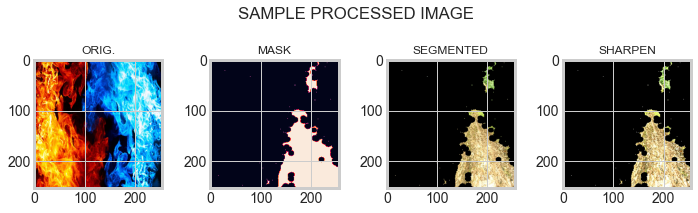

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 true
1823  val_index 
incorrect
[0.] prediction
non-wildfire/flame-fractal-fire-isolated-on-white-1.jpg image_name


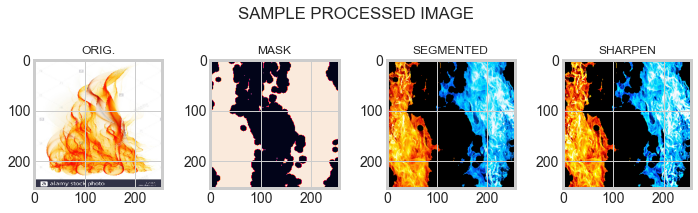

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 true
1433  val_index 
incorrect
[0.] prediction
non-wildfire/Woman-suffers-burns-in-building-fire.jpg image_name


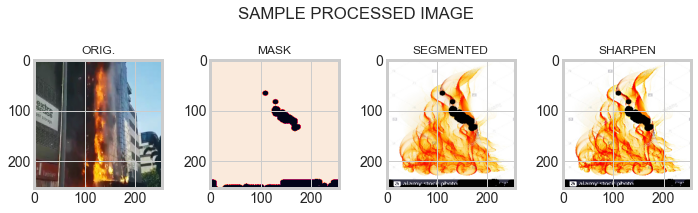

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 true
866  val_index 
incorrect
[0.] prediction
non-wildfire/fire-background-1.jpg image_name


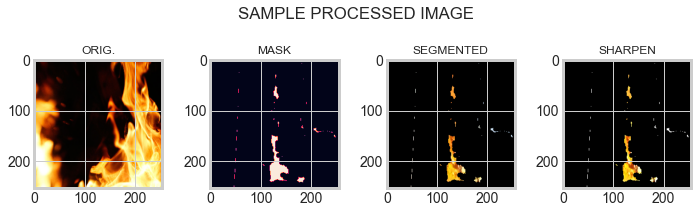

1 true
1230  val_index 
incorrect
[0.] prediction
non-wildfire/7010040-37F_Lest_We_Forget_01.jpg image_name


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


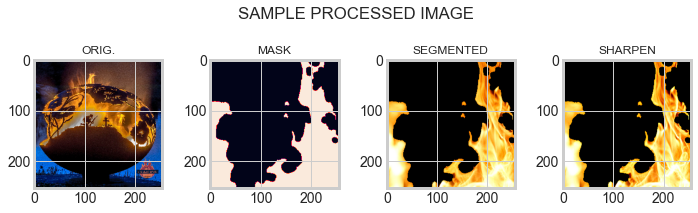

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 true
614  val_index 
incorrect
[1.] prediction
wildfire/forest-fire-13.jpg image_name


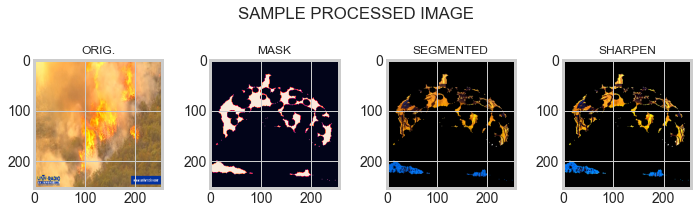

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 true
373  val_index 
incorrect
[1.] prediction
wildfire/yellowstone_during1.jpg image_name


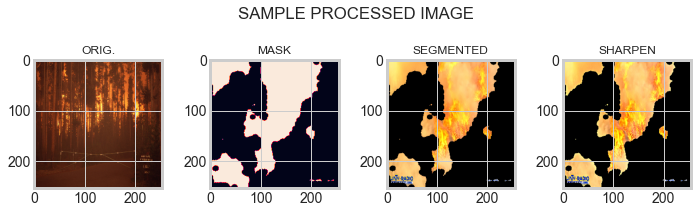

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 true
228  val_index 
incorrect
[1.] prediction
wildfire/0c848e2b-e37f-4f4c-b7f0-a4362d79e0a5.jpg image_name


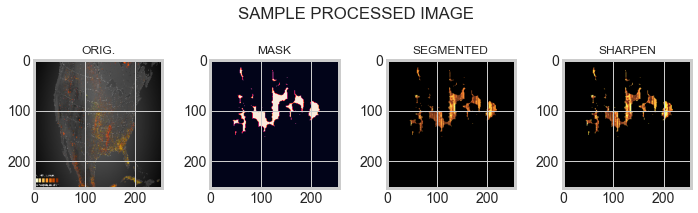

In [66]:
# 0 = no wildfire
# 1 = wildfire
c = 0
INPUT_SIZE=255
for pred, val_index in zip(predictions, val_indicies):
    if c >= 10:
        break
    if y_val[val_index] != pred:
        print(y_val[val_index], 'true')
        print(val_index, ' val_index ')
        print('incorrect')
        print(pred, 'prediction')
        fig, ax = plt.subplots(1, 4, figsize=(10, 5));
        plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=0.8)
        plt.tight_layout()

        image_name = df['file'][val_index]
        #mask
        image_mask = create_mask_for_plant(img)
        #segmentation
        image_segmented = segment_image(img)
        #sharpen the image
        image_sharpen = sharpen_image(image_segmented)
        ax[0].set_title('ORIG.', fontsize=12)
        ax[1].set_title('MASK', fontsize=12)
        ax[2].set_title('SEGMENTED', fontsize=12)
        ax[3].set_title('SHARPEN', fontsize=12)
        
        print(image_name, 'image_name')
        img = read_img(image_name,(255,255))
        ax[0].imshow(img/255)
        ax[1].imshow(image_mask)
        ax[2].imshow(image_segmented)
        plt.imshow(image_sharpen)
        plt.show()
        c +=1